# Training Supervised Model for B-scan slices binary classification

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset,random_split
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
import os

import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/clinical_ai/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/clinical_ai/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/clinical_ai/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/clinical_ai/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launc

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/clinical_ai/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/clinical_ai/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/clinical_ai/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/clinical_ai/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launc

AttributeError: _ARRAY_API not found

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [3]:
# FOR Supervised Model
class CustomDataset(Dataset):
    def __init__(self, root_dir, color, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.color = color
        self.data = []

        for label, folder in enumerate(["healthy_no", "healthy_yes"]):
            folder_path = os.path.join(root_dir, folder)
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                if os.path.isfile(img_path):
                    self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert(self.color)

        if self.transform:
            image = self.transform(image)

        return image, label

class DataLoaderModule:
    def __init__(self, root_dir, color, batch_size=32, test_split=0.2):
        self.root_dir = root_dir
        self.color = color
        self.batch_size = batch_size
        self.test_split = test_split

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
            transforms.RandomRotation(degrees=(-10, 10)),  # Random rotation between -10 to 10 degrees
            transforms.ToTensor()  # Convert images to tensors
        ])

        self.dataset = CustomDataset(root_dir, color, transform=self.transform)
        self.train_loader, self.test_loader = self.split_dataset()

    def split_dataset(self):
        print(f"total dataset: {len(self.dataset)}")
        test_size = int(len(self.dataset) * self.test_split)
        train_size = len(self.dataset) - test_size
        train_set, test_set = random_split(self.dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_set, batch_size=self.batch_size, shuffle=False)

        print(f"Train set size: {train_size}")
        print(f"Test set size: {test_size}")

        return train_loader, test_loader

In [ ]:
class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()

        # Load VGG-16 model
        self.vgg16 = models.vgg16(pretrained=pretrained)

        # Freeze convolutional layers (optional)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True  # Set to True if you want to fine-tune

        # Modify the classifier head for binary classification
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # VGG-16's default input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),  # Custom hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit (for binary classification)
        )

    def forward(self, x):
        return self.vgg16(x)  # No sigmoid, return raw logits

# Instantiate the model
vgg_model = VGG16BinaryClassifier(pretrained=True)
print(vgg_model)

/opt/anaconda3/envs/clinical_ai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/clinical_ai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16BinaryClassifier(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

In [74]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Initial standard convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        # Dilated convolutional layers
        self.dilated3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, dilation=(3, 2), padding=3)
        self.dilated4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, dilation=(6, 4), padding=6)
        self.dilated5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, dilation=(12, 8), padding=12)
        self.dilated6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, dilation=(24, 16), padding=24)
        self.dilated7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, dilation=(48, 32), padding=48)

        # Feature bottleneck
        self.conv9 = nn.Conv2d(in_channels=160, out_channels=128, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1)
        self.conv11 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)  # Output layer (logits)

        # Leaky ReLU activation function
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

        # Fully connected layers
        self.hidden1 = nn.Linear(64, 32)
        self.hidden2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x1 = self.leaky_relu(self.conv1(x))
        x2 = self.leaky_relu(self.conv2(x1))

        # Use checkpointing for memory efficiency
        d3 = self.dilated3(x2)
        d4 = self.dilated4(d3)
        d5 = self.dilated5(d4)
        d6 = self.dilated6(d5)
        d7 = self.dilated7(d6)

        # print(d7.shape)
        d7 = F.interpolate(d7, size=(x2.shape[2], x2.shape[3]), mode="bilinear", align_corners=False)
        concat = torch.cat((x2, d7), dim=1)

        x9 = self.leaky_relu(self.conv9(concat))
        x10 = self.leaky_relu(self.conv10(x9))
        x11 = self.conv11(x10)

        # Global Average Pooling to reduce spatial dimensions to 1x1
        x11 = F.adaptive_avg_pool2d(x11, (1, 1))  # Output shape: [batch_size, 1, 1, 1]

        # Flatten the output to shape [batch_size, 1]
        # print(x11.shape)
        x11 = torch.flatten(x11,start_dim=1)
        # print(x11.shape)

        # x12 = self.leaky_relu(self.hidden1(x11))
        # x12 = self.dropout(x12)
        # x13 = self.leaky_relu(self.hidden2(x12))
        # x13 = self.dropout(x13)
        # x14 = self.output(x13)

        return x11

# Model
cnn_model = CNN()
print(cnn_model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dilated3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 2))
  (dilated4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 4))
  (dilated5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 8))
  (dilated6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(24, 24), dilation=(24, 16))
  (dilated7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(48, 48), dilation=(48, 32))
  (conv9): Conv2d(160, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv11): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (hidden1): Linear(in_features=64, out_features=32, bias=True)
  (hidden2): Linear(in_featur

In [5]:
def plot_training_results(train_loss, val_loss, train_acc, val_acc, y_true, y_pred):
    """
    Plots training/validation loss and confusion matrices for training and validation data.

    Parameters:
    - train_loss (list): List of training loss per epoch.
    - val_loss (list): List of validation loss per epoch.
    - y_train_true (array-like): True labels for training data.
    - y_train_pred (array-like): Predicted labels for training data.
    - y_val_true (array-like): True labels for validation data.
    - y_val_pred (array-like): Predicted labels for validation data.
    - class_names (list): List of class names for confusion matrix.

    Returns:
    - A single figure with three subplots.
    """
    epochs = range(1, len(train_loss) + 1)

    # Create figure with 3 subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1️⃣ Plot Train & Validation Loss
    axes[0].plot(epochs, train_loss, label="Train Loss", marker='o')
    axes[0].plot(epochs, val_loss, label="Validation Loss", marker='s')
    axes[0].set_title("Training & Validation Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # 2️⃣ Plot Train Accuracy
    axes[1].plot(epochs, train_acc, label="Train Acc", marker='o')
    axes[1].plot(epochs, val_acc, label="Validation ACC", marker='s')
    axes[1].set_title("Training & Validation Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    # 3️⃣ Validation Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Oranges", xticklabels=["healthy_no", "healthy_yes"], yticklabels=["healthy_no", "healthy_yes"], ax=axes[2])
    axes[2].set_title("Confusion Matrix")
    axes[2].set_xlabel("Predicted")
    axes[2].set_ylabel("Actual")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [8]:
def train_model(model, train_loader, val_loader, num_epochs, lr, checkpoint_path="best_CNN_model.pth"):
    # Define loss function
    criterion = nn.BCEWithLogitsLoss()
    model.to(device)

    # Store losses and accuracy
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    best_acc = 0  

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    for epoch in range(num_epochs):
        torch.cuda.empty_cache()

        # Training phase
        model.train()
        train_epoch_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()

            # Store predictions
            preds = (torch.sigmoid(outputs) > 0.5).float()

            # Update accuracy counts
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        avg_train_loss = train_epoch_loss / len(train_loader)
        train_accuracy = correct / total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_accuracy)

        # Validation phase (no gradient computation)
        model.eval()
        val_epoch_loss, val_correct, val_total = 0.0, 0, 0

        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()

                # Store predictions
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                # Collect predictions and labels for confusion matrix
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

        avg_val_loss = val_epoch_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_accuracy)

        # Concatenate all predictions and labels
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        # Print training progress
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

        # Save the best model (based on validation loss)
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path} (Best Val Loss: {best_acc:.4f})")

    print("## Training complete! ##")
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, all_preds.numpy(), all_labels.numpy()

In [9]:
# Data Engineering
batch_size = 16
root_path = "labeled_dataset"
data_module = DataLoaderModule(root_dir=root_path, color = "RGB", batch_size=batch_size)
train_loader, test_loader = data_module.train_loader, data_module.test_loader

total dataset: 830
Train set size: 664
Test set size: 166


100%|██████████| 11/11 [00:03<00:00,  3.54it/s]


Epoch [1/10] - Train Loss: 0.5487 | Train Acc: 0.6898 | Val Loss: 0.4078 | Val Acc: 0.8072
Checkpoint saved at best_VGG_model.pth (Best Val Loss: 0.8072)


100%|██████████| 11/11 [00:02<00:00,  3.76it/s]


Epoch [2/10] - Train Loss: 0.3552 | Train Acc: 0.8479 | Val Loss: 0.2595 | Val Acc: 0.9096
Checkpoint saved at best_VGG_model.pth (Best Val Loss: 0.9096)


100%|██████████| 11/11 [00:02<00:00,  3.69it/s]


Epoch [3/10] - Train Loss: 0.2908 | Train Acc: 0.8750 | Val Loss: 0.2027 | Val Acc: 0.9096


100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Epoch [4/10] - Train Loss: 0.2841 | Train Acc: 0.8870 | Val Loss: 0.2098 | Val Acc: 0.9157
Checkpoint saved at best_VGG_model.pth (Best Val Loss: 0.9157)


100%|██████████| 11/11 [00:03<00:00,  3.65it/s]


Epoch [5/10] - Train Loss: 0.2273 | Train Acc: 0.9081 | Val Loss: 0.1821 | Val Acc: 0.9157


100%|██████████| 11/11 [00:03<00:00,  3.40it/s]


Epoch [6/10] - Train Loss: 0.2306 | Train Acc: 0.9157 | Val Loss: 0.2034 | Val Acc: 0.9036


100%|██████████| 11/11 [00:03<00:00,  3.51it/s]


Epoch [7/10] - Train Loss: 0.1884 | Train Acc: 0.9262 | Val Loss: 0.2132 | Val Acc: 0.9096


100%|██████████| 11/11 [00:03<00:00,  3.49it/s]


Epoch [8/10] - Train Loss: 0.1663 | Train Acc: 0.9322 | Val Loss: 0.2482 | Val Acc: 0.9096


100%|██████████| 11/11 [00:03<00:00,  3.45it/s]


Epoch [9/10] - Train Loss: 0.1538 | Train Acc: 0.9443 | Val Loss: 0.1907 | Val Acc: 0.9337
Checkpoint saved at best_VGG_model.pth (Best Val Loss: 0.9337)


100%|██████████| 11/11 [00:03<00:00,  3.05it/s]


Epoch [10/10] - Train Loss: 0.1438 | Train Acc: 0.9503 | Val Loss: 0.1906 | Val Acc: 0.9096
## Training complete! ##


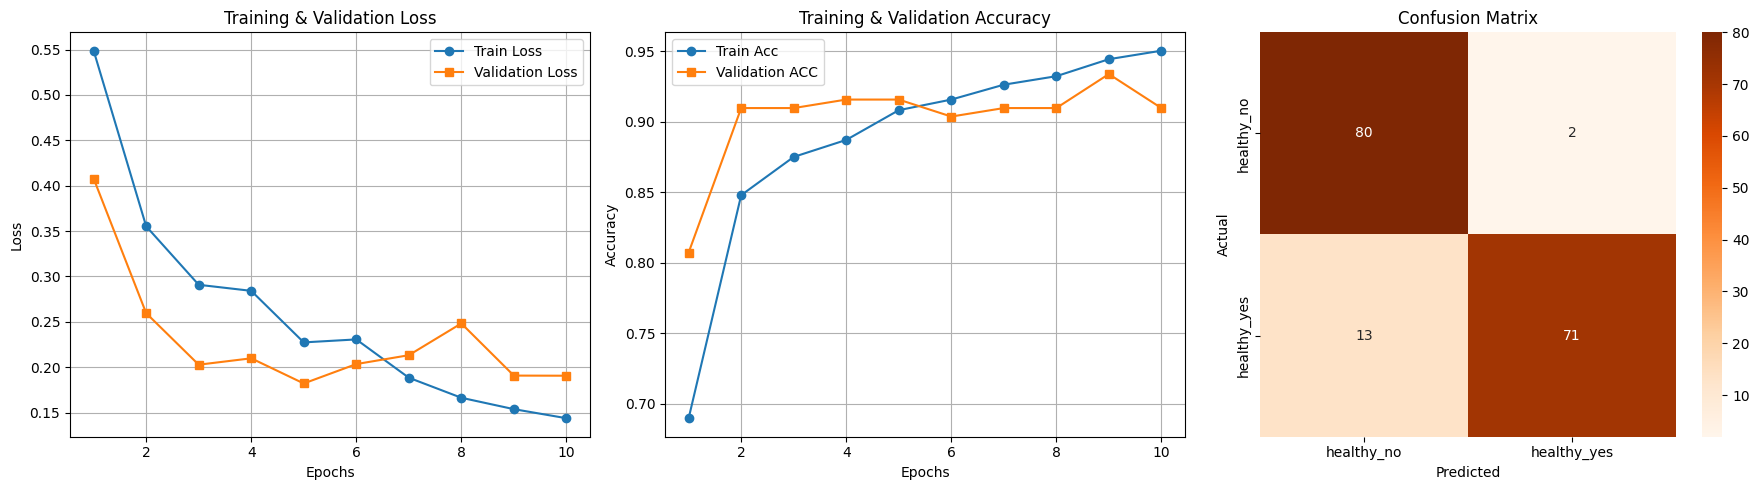

In [10]:
# VGG16
num_epochs = 10
lr = 0.0001

# Training
train_loss_history, val_loss_history, train_acc, val_acc, preds, labels = train_model(vgg_model, train_loader, test_loader, num_epochs, lr, "best_VGG_model.pth")
plot_training_results(train_loss_history, val_loss_history, train_acc, val_acc,preds, labels)

### CNN model
ref: https://opg.optica.org/boe/fulltext.cfm?uri=boe-8-11-5160&id=375684

In [ ]:
# Data Engineering
batch_size = 16
root_path = "labeled_dataset"
data_module = DataLoaderModule(root_dir=root_path, color = "L", batch_size=batch_size)
train_loader, test_loader = data_module.train_loader, data_module.test_loader

100%|██████████| 11/11 [00:05<00:00,  1.83it/s]


Epoch [1/5] - Train Loss: 0.6940 | Train Acc: 0.4849 | Val Loss: 0.6942 | Val Acc: 0.4398
Checkpoint saved at best_CNN_model.pth (Best Val Loss: 0.4398)


100%|██████████| 11/11 [00:05<00:00,  1.88it/s]


Epoch [2/5] - Train Loss: 0.6942 | Train Acc: 0.5030 | Val Loss: 0.6913 | Val Acc: 0.5602
Checkpoint saved at best_CNN_model.pth (Best Val Loss: 0.5602)


100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


Epoch [3/5] - Train Loss: 0.6930 | Train Acc: 0.5151 | Val Loss: 0.6913 | Val Acc: 0.5602


100%|██████████| 11/11 [00:08<00:00,  1.32it/s]


Epoch [4/5] - Train Loss: 0.6929 | Train Acc: 0.5151 | Val Loss: 0.6905 | Val Acc: 0.5602


100%|██████████| 11/11 [00:07<00:00,  1.41it/s]


Epoch [5/5] - Train Loss: 0.6931 | Train Acc: 0.5151 | Val Loss: 0.6903 | Val Acc: 0.5602
## Training complete! ##


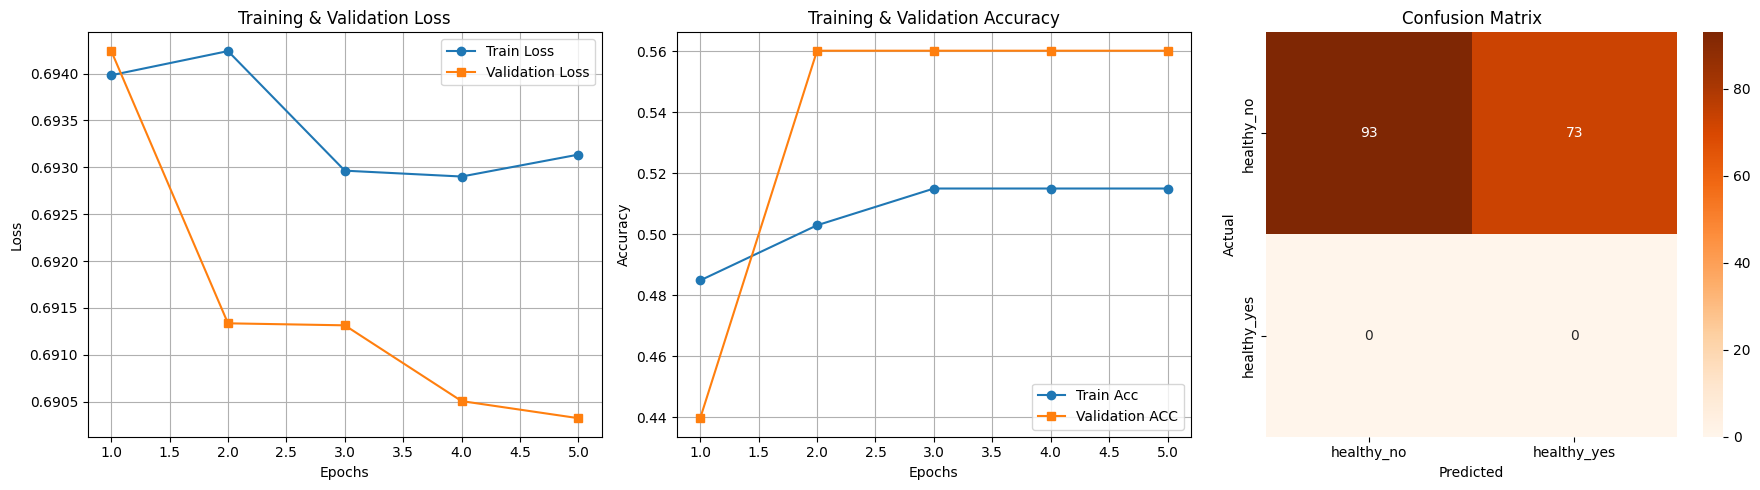

In [75]:
# CNN
num_epochs = 5
lr = 0.0001

# Training
train_loss_history, val_loss_history, train_acc, val_acc, preds, labels = train_model(cnn_model, train_loader, test_loader, num_epochs, lr,"best_CNN_model.pth")
plot_training_results(train_loss_history, val_loss_history, train_acc, val_acc,preds, labels)

# Test model

In [11]:
from torchvision import transforms
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import random
import numpy as np
import time

In [12]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [13]:
def set_seed(seed=42):
    torch.manual_seed(seed)  # Set seed for PyTorch
    np.random.seed(seed)  # Set seed for NumPy
    random.seed(seed)  # Set seed for Python's random module

    # Ensure reproducibility for GPU (MPS for Mac)
    torch.mps.manual_seed(seed)  # For MPS (Metal on Mac)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a fixed seed
set_seed(42)

In [14]:
# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.image_paths = []
        self.file_names = []
        self.transform = transform

        for root, _, files in os.walk(image_path):
            for file in files:
                if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
                    self.image_paths.append(os.path.join(root, file))
                    self.file_names.append(file)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        file_name = self.file_names[idx]

        image = Image.open(image_path).convert("RGB")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image, file_name  # Return both image tensor & filename
  
def get_transforms():
    return transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
          transforms.RandomRotation(degrees=(-10, 10)),  # Random rotation between -10 to 10 degrees
          transforms.ToTensor()  # Convert images to tensors
    ])

# Preprocess images & return DataLoader
def preprocess_image(image_path, batch_size=16):
    transform = get_transforms()
    dataset = ImageDataset(image_path, transform=transform)
    print(f"Total images: {len(dataset)}")
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return test_loader  # Returning DataLoader

In [ ]:
class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()

        # Load VGG-16 model
        self.vgg16 = models.vgg16(pretrained=pretrained)

        # Freeze convolutional layers (optional)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True  # Set to True if you want to fine-tune

        # Modify the classifier head for binary classification
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # VGG-16's default input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),  # Custom hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit (for binary classification)
        )

    def forward(self, x):
        return self.vgg16(x)  # No sigmoid, return raw logits

# Function to load the trained model
def load_model(model_path, device):
    # Instantiate the model
    model = VGG16BinaryClassifier(pretrained=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(model)
    return model


In [16]:
time = int(time.time())
time_to_save = str(time)

model_path = "best_VGG_model.pth"
volume_path = "sample_Bscan_slices/"
save_txt_path = "class_1_predictions_" + time_to_save + ".txt"

In [17]:
batch_size = 16
test_loader = preprocess_image(volume_path, batch_size=batch_size)

model = load_model(model_path,device)

Total images: 128


/opt/anaconda3/envs/clinical_ai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/clinical_ai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_40527/3542113885.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https

VGG16BinaryClassifier(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True

In [18]:
# Open file for writing predictions
with torch.no_grad(), open(save_txt_path, "a") as f:
    for images, filenames in tqdm(test_loader):
        images = images.to(device)  

        # Model inference
        outputs = model(images)
        predicted_labels = torch.sigmoid(outputs).round().int()  # Convert logits to binary labels

        # Save results
        fovea = 0
        for filename, label in zip(filenames, predicted_labels.cpu().numpy()):
            if label == 1:  # If predicted as class 1
                f.write(f"{filename} {label}\n")
                fovea += 1

        print(f"Batch Summary: fovea {fovea} images")

 12%|█▎        | 1/8 [00:00<00:02,  3.30it/s]

Batch Summary: fovea 4 images


 25%|██▌       | 2/8 [00:00<00:01,  3.39it/s]

Batch Summary: fovea 3 images


 38%|███▊      | 3/8 [00:00<00:01,  3.46it/s]

Batch Summary: fovea 1 images


 50%|█████     | 4/8 [00:01<00:01,  3.43it/s]

Batch Summary: fovea 2 images


 62%|██████▎   | 5/8 [00:01<00:00,  3.42it/s]

Batch Summary: fovea 2 images


 75%|███████▌  | 6/8 [00:01<00:00,  3.43it/s]

Batch Summary: fovea 3 images


 88%|████████▊ | 7/8 [00:02<00:00,  3.41it/s]

Batch Summary: fovea 1 images


100%|██████████| 8/8 [00:02<00:00,  3.40it/s]

Batch Summary: fovea 5 images


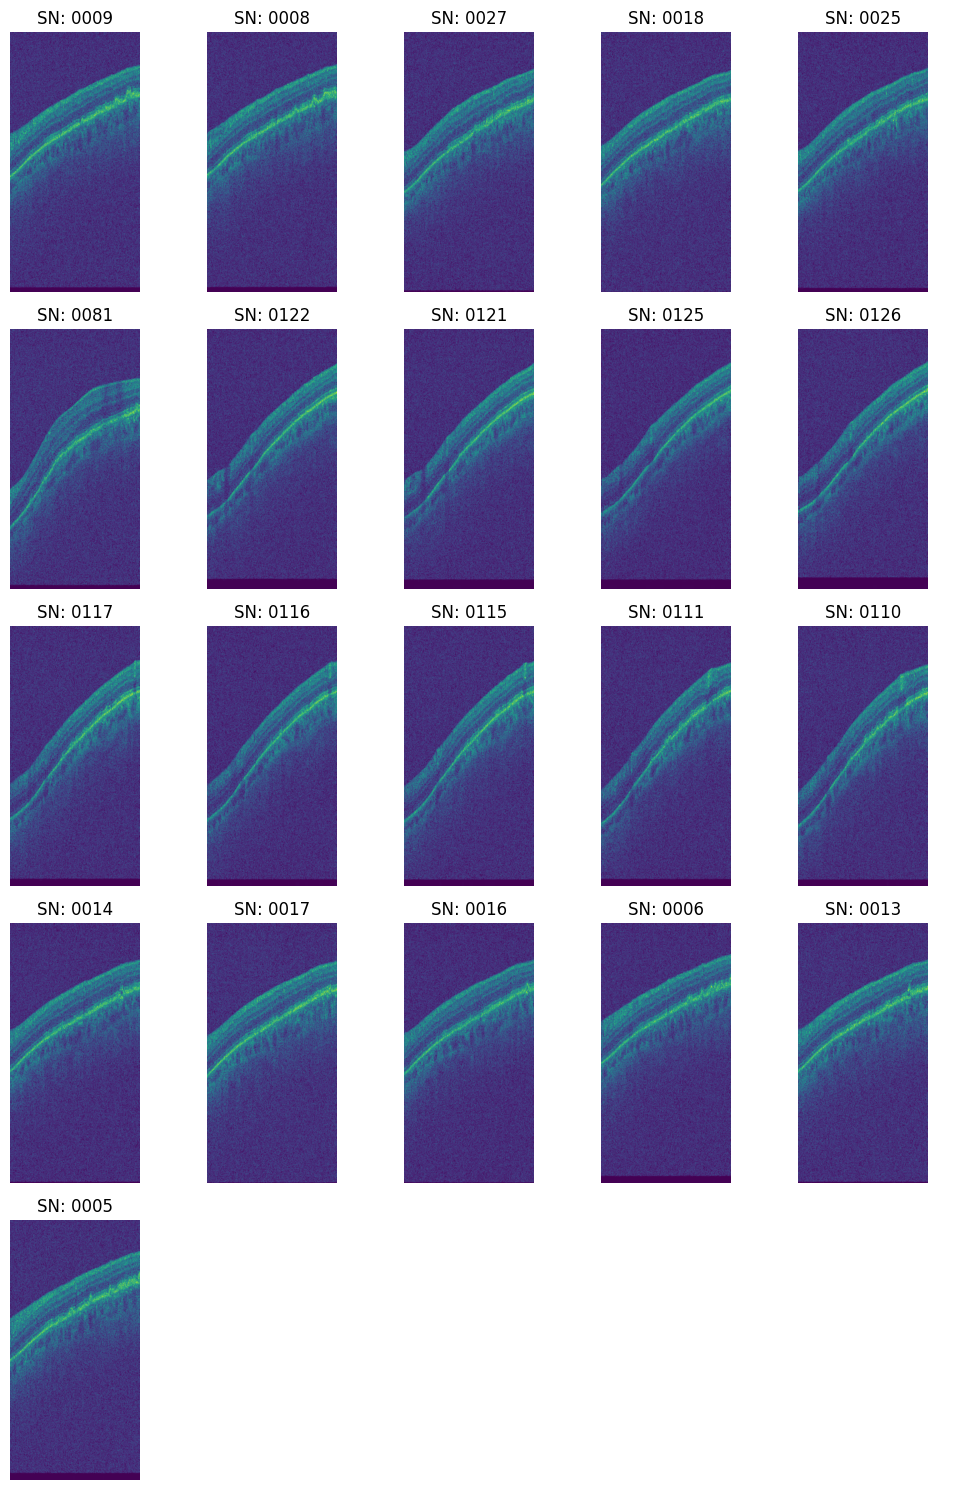

In [19]:
import math

# Read the saved text file
with open(save_txt_path, "r") as f:
    class_1_images = [line.strip().split() for line in f.readlines()]

# Function to extract serial number from img_name
def extract_serial_number(img_name):
    return img_name.split("_")[-1].split(".")[0]  # Extract last part before ".jpg"

# Convert labels to integers correctly and filter images where label == 1
class_1_images = [(img_name, extract_serial_number(img_name)) for img_name, label in class_1_images if int(label.strip("[]")) == 1]

num_images_to_show = len(class_1_images)
images_per_row = 5
num_rows = math.ceil(num_images_to_show / images_per_row)

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(10, 3 * num_rows))
axes = axes.flatten()  # Flatten to make indexing easier

for idx, (img_name, serial_number) in enumerate(class_1_images[:num_images_to_show]):
    img = Image.open(os.path.join(volume_path, img_name))  # Load image
    axes[idx].imshow(img)
    axes[idx].axis("off")
    axes[idx].set_title(f"SN: {serial_number}")  # Display serial number as title

# Hide unused subplots
for idx in range(num_images_to_show, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()